# Evaluate 

In [1]:
import sys
print(sys.executable, sys.version)


import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import trimesh

from os.path import join, abspath
from IPython.display import display, HTML
from glob import glob

# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

%matplotlib inline

# for local import 
sys.path.append(abspath('..'))

from main.config import Config
from main.model import Model
from main.dataset import Dataset
from main.smpl import Smpl

from vis_util import draw_2d_on_image, show_2d_pose, show_3d_pose

/home/mmc-user/.virtualenvs/hmr2-notebook/bin/python3 3.6.8 (default, Oct  7 2019, 12:59:55) 
[GCC 8.3.0]


In [2]:
#eval_date = '02052020-143216'
#eval_date = '04052020-181359'
# eval_date = '08052020-102709' # 3d with regenerated H36M 
# eval_date = '22052020-165507' # 3d with total capture and regenerated H36M 
eval_date = '25052020-171905' # 3d with total capture and regenerated H36M but w/ 3D groundtruth

class EvalConfig(Config):
    BATCH_SIZE = 64
    ENCODER_ONLY = True
    LOG_DIR = join('/', 'data', 'ssd1', 'russales', 'logs', eval_date)
    DATA_DIR = join('/', 'data', 'ssd1', 'russales', 'tfrecords')
    DATASETS = ['mpii_3d', 'h36m', 'total_cap']
    # RESTORE_PATH = join(LOG_DIR, 'ckpt-6')

# class Config is implemented as singleton, inizialize subclass first!
config = EvalConfig()

In [3]:
# inizialize model 
model = Model()

Saving logs to /data/ssd1/russales/logs/25052020-171905

Configurations:
BATCH_SIZE                     64
DATASETS                       ['mpii_3d', 'h36m', 'total_cap']
DATA_DIR                       /data/ssd1/russales/tfrecords
DISCRIMINATOR_LEARNING_RATE    0.0001
DISCRIMINATOR_LOSS_WEIGHT      1
DISCRIMINATOR_WEIGHT_DECAY     0.0001
ENCODER_INPUT_SHAPE            (224, 224, 3)
ENCODER_ONLY                   True
EPOCHS                         55
GENERATOR_2D_LOSS_WEIGHT       60.0
GENERATOR_3D_LOSS_WEIGHT       60.0
GENERATOR_LEARNING_RATE        1e-05
GENERATOR_WEIGHT_DECAY         0.0001
ITERATIONS                     3
JOINT_TYPE                     cocoplus
LOG_DIR                        /data/ssd1/russales/logs/25052020-171905
NUM_CAMERA_PARAMS              3
NUM_JOINTS                     23
NUM_JOINTS_GLOBAL              24
NUM_KP2D                       19
NUM_KP3D                       14
NUM_PARALLEL                   16
NUM_POSE_PARAMS                72
NUM_SHAPE_PARAM

### run evaluation

In [4]:
result = model.test()

initialize test dataset...
Done (t=0.36634087562561035)

Start of Testing



Time taken for testing 262.2608745098114 sec



### sort results by sequence 

In [5]:
all_kp3d_mpjpe = result['kp3d_mpjpe'].numpy()
all_kp3d_mpjpe_aligned = result['kp3d_mpjpe_aligned'].numpy()
sequences = result['seq'].numpy()

### evaluate per sequence 

In [6]:
eval_dict = {}
indices = range(len(sequences))
for i, sequence in zip(indices, sequences):
    sequence = sequence.decode("utf-8")
    if ' 2_' in sequence or ' 3_' in sequence:
        continue
    mpjpe_tuple = tuple([all_kp3d_mpjpe[i], all_kp3d_mpjpe_aligned[i]])
    if sequence not in eval_dict:
        eval_dict[sequence] = [mpjpe_tuple]
    else:
        eval_dict[sequence].append(mpjpe_tuple)

In [7]:
names, data = eval_dict.keys(), np.ndarray(shape=(len(eval_dict), 9), dtype=np.float32)

indices = range(len(names))
for i, value in zip(indices, eval_dict.values()):
    values_per_seq = np.asarray(value, dtype=np.float32)
    mpjpe = values_per_seq[:, 0, :]
    mpjpe_aligned = values_per_seq[:, 1, :]
    
    mean_mpjpe_aligned = np.mean(mpjpe_aligned)
    mean_mpjpe = np.mean(mpjpe)
    
    data[i, 0] = mean_mpjpe_aligned  # mean_error_aligned
    data[i, 1] = mean_mpjpe  # mean_error
    data[i, 2] = np.median(mpjpe)  # median_error
    data[i, 3] = np.std(mpjpe)  # standard deviation
    data[i, 4] = mpjpe.min()  # min
    data[i, 5] = mpjpe.max()  # max
    data[i, 6] = np.percentile(mpjpe, 25)  # 25 percentile
    data[i, 7] = np.percentile(mpjpe, 50)  # 50 percentile
    data[i, 8] = np.percentile(mpjpe, 75)  # 75 percentile
        
columns = ['Mean Aligned', 'Mean', 'Median', 'Standard Deviation', 'Min', 'Max', '25%', '50%', '75%']
df_seq = pd.DataFrame(data, index=names, columns=columns)

df_seq = df_seq.sort_values(df_seq.columns[0]) # sort by ascending mean aligned

display(HTML(df_seq.to_html()))

,Mean Aligned,Mean,Median,Standard Deviation,Min,Max,25%,50%,75%
h36m_sub11_Purchases_cam60457274,48.507908,77.142700,67.823006,49.660122,2.188574,391.435211,43.570602,67.823006,100.967468
h36m_sub11_Posing 1_cam60457274,50.947800,78.810783,67.485031,52.750408,3.169470,436.700439,41.625977,67.485031,103.419350
h36m_sub11_Purchases 1_cam60457274,51.091099,84.837280,73.147629,68.753479,2.566844,889.584290,43.640865,73.147629,104.820679
h36m_sub11_Posing_cam60457274,55.771069,85.338142,74.944183,54.472755,3.973985,378.111267,43.502937,74.944183,118.030891
h36m_sub11_Directions 1_cam58860488,58.959637,170.582993,147.258850,113.511887,9.040103,570.069885,79.164223,147.258850,245.558929
h36m_sub11_Waiting 1_cam60457274,59.288059,91.474586,80.897034,59.018120,4.292966,385.052948,43.899239,80.897034,129.617737
h36m_sub11_Purchases_cam58860488,59.315342,136.635880,117.563522,93.621307,4.375538,626.518982,78.261520,117.563522,178.350510
h36m_sub11_Waiting_cam60457274,59.752628,89.164040,77.240189,60.567833,6.440550,461.370728,41.300728,77.240189,122.211723
h36m_sub11_Directions_cam58860488,59.975445,194.284409,186.546616,121.388634,9.533362,573.425781,103.018211,186.546616,273.691223
h36m_sub9_Posing 1_cam60457274,60.539043,100.184441,86.726151,69.243217,0.574507,999.797241,55.200439,86.726151,129.410675


In [ ]:
df_seq.describe()

### evaluate per joint

In [32]:
lsp_joints = ['ankle_r', 'knee_r', 'hip_r', 'hip_l', 'knee_l', 
             'ankle_l', 'wrist_r', 'elbow_r', 'shoulder_r', 
             'shoulder_l', 'elbow_l', 'wrist_l', 'neck', 'brain']

data = np.ndarray(shape=(14, 9), dtype=float)
for i, _ in enumerate(lsp_joints):
    data[i, 0] = np.mean(all_kp3d_mpjpe_aligned[:, i])  # mean_error_aligned
    data[i, 1] = np.mean(all_kp3d_mpjpe[:, i])  # mean_error
    data[i, 2] = np.median(all_kp3d_mpjpe[:, i])  # median_error
    data[i, 3] = np.std(all_kp3d_mpjpe[:, i])  # standard deviation
    data[i, 4] = all_kp3d_mpjpe[:, i].min()  # min
    data[i, 5] = all_kp3d_mpjpe[:, i].max()  # max
    data[i, 6] = np.percentile(all_kp3d_mpjpe[:, i], 25)  # 25 percentile
    data[i, 7] = np.percentile(all_kp3d_mpjpe[:, i], 50)  # 50 percentile
    data[i, 8] = np.percentile(all_kp3d_mpjpe[:, i], 75)  # 75 percentile
        
columns = ['Mean Aligned', 'Mean', 'Median', 'Standard Deviation', 'Min', 'Max', '25%', '50%', '75%']
df_joint = pd.DataFrame(data, index=lsp_joints, columns=columns)
df_joint = df_joint.sort_values(df_joint.columns[0])

display(HTML(df_joint.to_html()))

,Mean Aligned,Mean,Median,Standard Deviation,Min,Max,25%,50%,75%
neck,37.991413,95.166519,84.557228,59.792713,2.079608,921.281982,55.880686,84.557228,119.901682
shoulder_r,45.938362,111.112000,98.019135,68.370575,1.611760,911.151428,66.157063,98.019131,140.387394
shoulder_l,49.422485,112.247101,99.656967,64.485710,1.926884,904.429016,68.025663,99.656971,142.806458
hip_r,68.811394,43.076820,37.882843,29.155039,0.957993,267.694702,24.075443,37.882845,53.602100
hip_l,69.983376,43.076824,37.882843,29.155033,0.958100,267.694824,24.075609,37.882843,53.602160
knee_r,71.314156,97.654129,81.674408,70.276291,0.240282,981.215027,53.133043,81.674412,121.793034
elbow_l,72.669121,139.555130,116.811783,96.837769,1.615541,1376.256104,76.838854,116.811787,174.149479
elbow_r,74.509850,141.916412,118.746109,96.802551,1.640829,1180.665527,80.813240,118.746105,175.100761
brain,74.617455,136.058517,119.018112,91.199860,1.105133,1315.030762,72.914852,119.018108,176.989033
knee_l,75.688118,104.892647,87.608429,71.945953,1.519416,933.226196,61.570123,87.608425,124.805193


In [33]:
df_joint.describe()

,Mean Aligned,Mean,Median,Standard Deviation,Min,Max,25%,50%,75%
count,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000
mean,75.481613,120.936675,102.475096,81.946342,1.437847,1073.117968,67.547478,102.475096,151.660552
std,22.938145,42.840962,34.603244,31.141806,0.496673,417.605419,22.859184,34.603244,54.144854
min,37.991413,43.076820,37.882843,29.155033,0.240282,267.694702,24.075443,37.882843,53.602100
25%,69.104389,99.463758,85.320028,65.456926,1.117214,913.684067,57.303045,85.320027,122.546073
50%,73.589485,124.152809,108.234375,81.572906,1.613650,1080.940277,70.470258,108.234379,158.477968
75%,85.884209,147.810246,122.329781,104.922768,1.781560,1431.118622,80.234448,122.329780,187.037927
max,115.772560,180.943298,149.180023,127.278198,2.079608,1513.864868,98.893976,149.180023,225.186256


### evaluate overall

In [35]:
all_mpjpe_aligned = np.mean(all_kp3d_mpjpe_aligned)
all_mpjpe = np.mean(all_kp3d_mpjpe)

print('Mean Aligned: {:.3f} --- Mean: {:.3f}'.format(all_mpjpe_aligned, all_mpjpe))

Mean Aligned: 75.482 --- Mean: 120.937


In [12]:
percentiles = [10, 30, 50, 70, 90]
data = np.ndarray(shape=(5, 2), dtype=float)
for i, percentile in enumerate(percentiles):
    data[i, 0] = np.percentile(all_kp3d_mpjpe_aligned, percentile)
    data[i, 1] = np.percentile(all_kp3d_mpjpe, percentile)

columns = ['10%', '30%', '50%', '70%', '90%']
df_percentiles = pd.DataFrame(data.T, index=['Mean Aligned', 'Mean'], columns=columns)
df_percentiles

,10%,30%,50%,70%,90%
Mean Aligned,25.658395,43.157219,60.957533,85.591862,140.022665
Mean,34.440192,65.002920,97.488365,140.142064,229.925357


In [36]:
def eval_per_dataset(name):
    len_ds = len([k for k in eval_dict.keys() if name in k])
    data = []

    indices = range(len(eval_dict.keys()))
    for i, (key, value) in zip(indices, eval_dict.items()):
        if name not in key:
            continue

        values_per_seq = np.asarray(value, dtype=np.float32)
        mpjpe = values_per_seq[:, 0, :]
        mpjpe_aligned = values_per_seq[:, 1, :]

        mean_mpjpe_aligned = np.mean(mpjpe_aligned)
        mean_mpjpe = np.mean(mpjpe)
        
        data.append(tuple([mean_mpjpe_aligned, mean_mpjpe]))  
        
    data = np.asarray(data, dtype=float)
    return np.mean(data[:, 0]), np.mean(data[:, 1])

In [37]:
mpjpe_aligned_mpi, mpjpe_mpi = eval_per_dataset('h36m')
print('HUMAN 3.6M')
print('Mean Aligned: {:.3f} --- Mean: {:.3f}'.format(mpjpe_aligned_mpi, mpjpe_mpi))

HUMAN 3.6M
Mean Aligned: 69.824 --- Mean: 104.803


In [38]:
mpjpe_aligned_mpi, mpjpe_mpi = eval_per_dataset('mpi')
print('MPII 3D')
print('Mean Aligned: {:.3f} --- Mean: {:.3f}'.format(mpjpe_aligned_mpi, mpjpe_mpi))

MPII 3D
Mean Aligned: 111.461 --- Mean: 170.702


In [39]:
mpjpe_aligned_tc, mpjpe_tc = eval_per_dataset('TC')
print('Total Capture')
print('Mean Aligned: {:.3f} --- Mean: {:.3f}'.format(mpjpe_aligned_tc, mpjpe_tc))

Total Capture
Mean Aligned: 82.687 --- Mean: 145.739


### save to csv

In [16]:
frames = [df_seq, df_joint]

dataframes = pd.concat(frames)
dataframes.to_csv('evaluation_{}.csv'.format(eval_date))

### Visualize

### run inference and visualize

In [17]:
example = join("/data/ssd1/russales/tfrecords/mpii_3d", "341_test.tfrecord")

# load record
dataset = Dataset()
dataset = dataset.get_data_for(example).shuffle(500, seed=14)

In [18]:
# run inference
for example in dataset.take(1):
    original = example
    result = model.detect(example[0])

#### show original image with ground truth

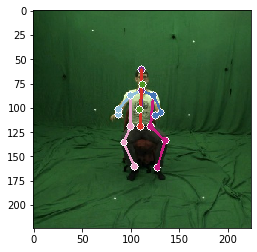

In [19]:
%matplotlib inline
image = original[0].numpy()
kp2d = original[1].numpy()[:, :2]
vis = original[1].numpy()[:, 2]

image = draw_2d_on_image(image, kp2d, vis=vis)
plt.imshow(image)
plt.show()

#### show image with predicted 2d keypoints

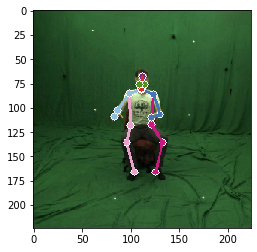

In [20]:
image = original[0].numpy()
kp2d = np.squeeze(result['kp2d'].numpy())
vis = original[1].numpy()[:, 2]
image = draw_2d_on_image(image, kp2d, vis=vis)
plt.imshow(image)
plt.show()

#### show both poses in seperate plots 

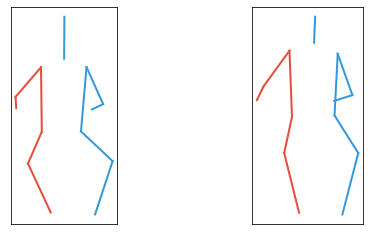

In [21]:
fig = plt.figure(figsize=plt.figaspect(0.5))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

vis = np.expand_dims(original[1].numpy()[:, 2], -1)

kp2d_real = original[1].numpy() * vis
show_2d_pose(kp2d_real, vis, ax1)

kp2d_pred = result['kp2d'].numpy() * vis
show_2d_pose(kp2d_pred, vis, ax2)

<IPython.core.display.Javascript object>


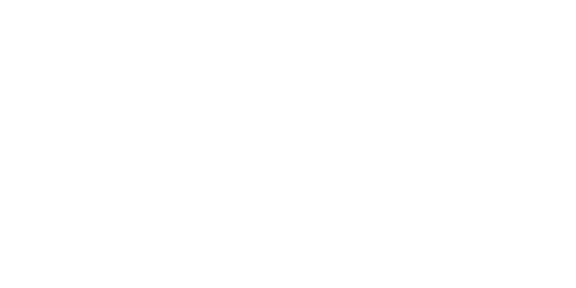

<IPython.core.display.Javascript object>


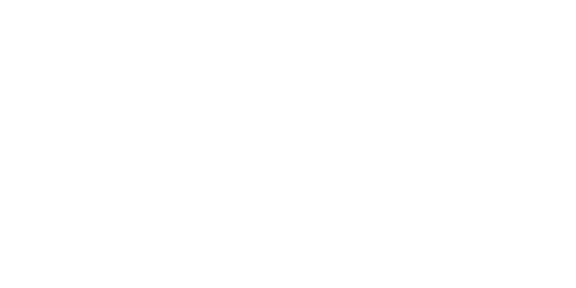

In [22]:
%matplotlib notebook
fig = plt.figure(figsize=plt.figaspect(0.5))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax2 = fig.add_subplot(1, 2, 2, projection='3d')

# only use predicted camera
camera = np.squeeze(result['cam'].numpy())

# Plot 3d gt
kp3d_real = original[2].numpy()
show_3d_pose(kp3d_real, ax1)

# Plot 3d predictions
kp3d_pred = np.squeeze(result['kp3d'].numpy())
kp3d_pred = kp3d_pred[:config.NUM_KP3D, :] # only lsp prediction
show_3d_pose(kp3d_pred, ax2)

In [23]:
image = original[0].numpy()

vertices = np.squeeze(result['vertices'].numpy())

In [24]:
from trimesh_renderer import TrimeshRenderer
renderer = TrimeshRenderer()

mesh = renderer.mesh(vertices)
mesh.show()

/home/mmc-user/.virtualenvs/hmr2-notebook/lib/python3.6/site-packages/trimesh/scene/scene.py:186: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if name in self.graph.nodes:
